In [1]:
import os
runs_dir = "runs"
runs = os.listdir(runs_dir)
print(len(runs))
runs = [os.path.join(runs_dir, i) for i in runs]
run_pics = [os.listdir(i) for i in runs]
run_pics = [[os.path.join(i, k) for k in j] for i,j in zip(runs, run_pics)]

235


In [2]:
no_go = [i[-3:] for i in run_pics if len(i) >=3]
go = [i[:max(0, min(3,len(i)-3))] for i in run_pics if len(i) >=3]

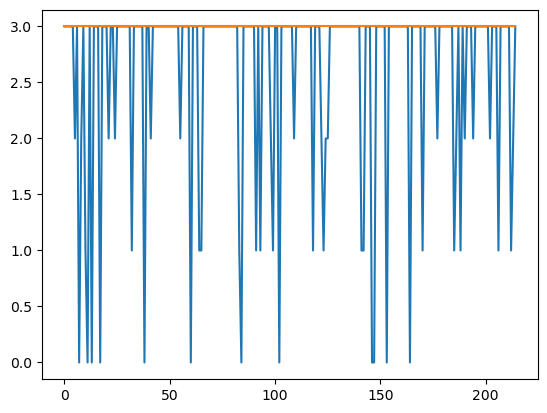

In [3]:
import matplotlib.pyplot as plt
plt.plot(range(len(go)), [len(i) for i in go])
plt.plot(range(len(no_go)), [len(i) for i in no_go])

In [4]:
[i for i in no_go if len(i) < 3]

[]

In [5]:
go_0 = []
go_1 = []
for i in no_go:
    go_0.extend(i)
for i in go:
    go_1.extend(i)
len(go_0), len(go_1)

(645, 558)

In [6]:
go_1[:5]

['runs\\00000\\0000000000+system.png',
 'runs\\00000\\0000000001+system.png',
 'runs\\00000\\0000000002+system.png',
 'runs\\00003\\0000000000+system.png',
 'runs\\00003\\0000000001+system.png']

In [7]:
from sklearn.model_selection import train_test_split
data = [*[(i,0) for i in go_0], *[(i,1) for i in go_1]]
tr, vl = train_test_split(data, test_size=0.2)
len(tr), len(vl)

(962, 241)

In [8]:
def file_and_lab(arr):
    return [i for i,j in arr], [j for i,j in arr]

In [9]:
import tensorflow as tf
train_ds = tf.data.Dataset.from_tensor_slices(file_and_lab(tr))
val_ds = tf.data.Dataset.from_tensor_slices(file_and_lab(vl))

In [10]:
list(train_ds.take(1))

[(<tf.Tensor: shape=(), dtype=string, numpy=b'runs\\00022\\0000000000+system.png'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>)]

In [11]:
def parse_element(file, label):
    image = tf.io.read_file(file)
    image = tf.io.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image /= 255 # No need for this cuz convert_image_dtype already divides by 255
    return image, label

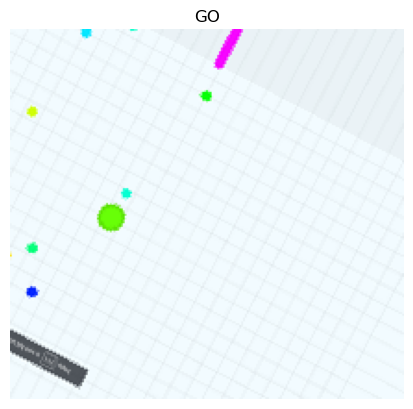

In [12]:
import matplotlib.pyplot as plt
def show(img, label):
    plt.figure()
    plt.imshow(img)
    plt.title("GO" if label.numpy()==1 else "NO GO")
    plt.axis('off')
show(*parse_element(*next(iter(train_ds))))

In [13]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=962>

In [14]:
train_ds = train_ds.map(parse_element)
val_ds = val_ds.map(parse_element)

In [15]:
next(iter(train_ds))[0].shape

TensorShape([200, 213, 3])

In [16]:
from models.model_1 import model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 209, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 41, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 37, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 1000)              1

In [17]:
model(tf.stack([next(iter(train_ds))[0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4463446, 0.5536554]], dtype=float32)>

In [18]:
model.compile("adam",
              tf.keras.losses.SparseCategoricalCrossentropy(),
              ['accuracy'],
              jit_compile=True)

In [19]:
hist = model.fit(
    train_ds.batch(100),
    validation_data=val_ds.batch(50),
    epochs=10,
    # batch_size=100,
    # validation_batch_size=50
)

Epoch 1/10
10/10 [==============================] - 45s 4s/step - loss: 0.7497 - accuracy: 0.5104 - val_loss: 0.6349 - val_accuracy: 0.5436
Epoch 2/10
10/10 [==============================] - 35s 3s/step - loss: 0.5751 - accuracy: 0.7256 - val_loss: 0.4763 - val_accuracy: 0.7759
Epoch 3/10
10/10 [==============================] - 36s 4s/step - loss: 0.5367 - accuracy: 0.7235 - val_loss: 0.5089 - val_accuracy: 0.8216
Epoch 4/10
10/10 [==============================] - 35s 4s/step - loss: 0.4757 - accuracy: 0.8129 - val_loss: 0.3883 - val_accuracy: 0.8216
Epoch 5/10
10/10 [==============================] - 35s 3s/step - loss: 0.4319 - accuracy: 0.8160 - val_loss: 0.3946 - val_accuracy: 0.8299
Epoch 6/10
10/10 [==============================] - 35s 4s/step - loss: 0.3610 - accuracy: 0.8576 - val_loss: 0.3510 - val_accuracy: 0.8548
Epoch 7/10
10/10 [==============================] - 35s 3s/step - loss: 0.3284 - accuracy: 0.8649 - val_loss: 0.3137 - val_accuracy: 0.8755
Epoch 8/10
10/10 [==

In [21]:
import pandas as pd
history = pd.DataFrame(hist.history)
history

,loss,accuracy,val_loss,val_accuracy
0,0.749662,0.510395,0.634861,0.543568
1,0.575054,0.725572,0.476333,0.775934
2,0.536675,0.723493,0.508922,0.821577
3,0.475704,0.812890,0.388348,0.821577
4,0.431931,0.816008,0.394626,0.829876
5,0.360992,0.857588,0.350960,0.854772
6,0.328351,0.864865,0.313694,0.875519
7,0.286365,0.890852,0.323705,0.854772
8,0.249076,0.895010,0.353619,0.850622
9,0.202369,0.926195,0.362147,0.887967


d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

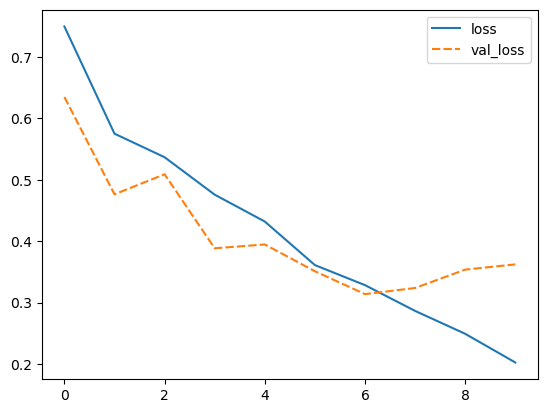

In [22]:
import seaborn as sns
ax = sns.lineplot(data=history[['loss', 'val_loss']])

d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\Agar.io\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

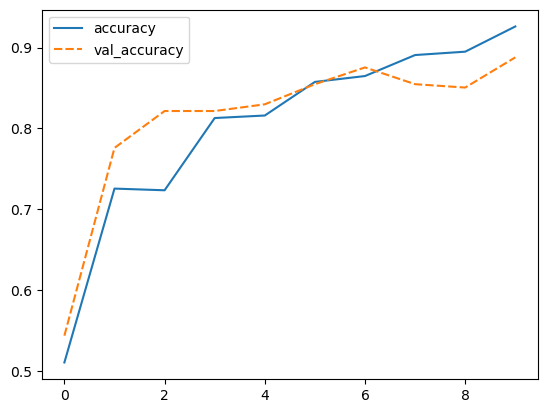

In [23]:
ax = sns.lineplot(data=history[['accuracy', 'val_accuracy']])

In [29]:
shots = list(val_ds.take(8).as_numpy_iterator())
shots = tf.stack([i for i,j in shots])
shots.shape

TensorShape([8, 200, 213, 3])

In [44]:
preds = model(shots)
preds.shape

TensorShape([8, 2])

In [46]:
preds

<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[1.4734916e-01, 8.5265082e-01],
       [1.9939429e-01, 8.0060571e-01],
       [6.3192284e-01, 3.6807707e-01],
       [1.3456172e-01, 8.6543822e-01],
       [9.9940860e-01, 5.9145916e-04],
       [1.0000000e+00, 2.5917650e-15],
       [6.8512447e-02, 9.3148756e-01],
       [9.9873120e-01, 1.2688375e-03]], dtype=float32)>

In [45]:
model.save("some.h5")

d:\Projects\Agar.io\env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
tf.argmax(preds)[1].numpy()

6

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rahul\AppData\Local\Temp\tmpplyyjebz\assets


INFO:tensorflow:Assets written to: C:\Users\rahul\AppData\Local\Temp\tmpplyyjebz\assets


In [48]:
tflite_path = "model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_path)

In [49]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['conv2d_input'], 'outputs': ['dense_3']}}

In [50]:
lite_model = interpreter.get_signature_runner('serving_default')
lite_model

In [62]:
ip = 'conv2d_input'

In [64]:
%%timeit
lite_model(conv2d_input=shots)

70.9 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
%%timeit
model(shots)

31.9 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
lite_model(conv2d_input=shots)

{'dense_3': array([[1.4734913e-01, 8.5265088e-01],
        [1.9939415e-01, 8.0060583e-01],
        [6.3192266e-01, 3.6807731e-01],
        [1.3456172e-01, 8.6543834e-01],
        [9.9940860e-01, 5.9145974e-04],
        [1.0000000e+00, 2.5917650e-15],
        [6.8512343e-02, 9.3148768e-01],
        [9.9873120e-01, 1.2688386e-03]], dtype=float32)}